# Part 7.3 - Document Similarity on Topic Modeling
---

### Papers Past Topic Modeling
<br/>

Ben Faulks - bmf43@uclive.ac.nz

Xiandong Cai - xca24@uclive.ac.nz

Yujie Cui - ycu23@uclive.ac.nz

In [1]:
import sys, gc
sys.path.insert(0, '../utils')
from utils import conf_pyspark, load_dataset
from utils_preplot import load_doctopic
#import warnings
#warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy.stats import entropy
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_colwidth', 120)
from matplotlib import pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
dpi=80

import datetime
print (datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

from pyspark.sql import functions as F
from pyspark.sql.types import *

# intiate PySpark
sc, spark = conf_pyspark()

sc

2019-02-03 20:24:37
[('spark.app.id', 'local-1549178690275'),
 ('spark.app.name', 'local'),
 ('spark.driver.maxResultSize', '8g'),
 ('spark.rdd.compress', 'True'),
 ('spark.driver.port', '42474'),
 ('spark.driver.host', '192.168.1.207'),
 ('spark.driver.memory', '62g'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.driver.cores', '6')]


<SparkContext master=local[*] appName=local>

**You read an article in the corpus, what if you want to know more about similar articles? In this part, we will calculate the similarity based on topic modeling and recommand similar articles for you.**

## 1 Load Data

**Meta Dataset:**

In [2]:
df_meta = load_dataset('meta', spark)
df_meta = df_meta.toPandas()
df_meta.head()

,id,publisher,region,date,ads
0,1854213,Albertland Gazette,Auckland,1862-06-14,False
1,1854215,Albertland Gazette,Auckland,1862-06-14,True
2,1854221,Albertland Gazette,Auckland,1862-06-14,False
3,1854224,Albertland Gazette,Auckland,1862-07-03,False
4,1854232,Albertland Gazette,Auckland,1863-08-01,True


**Topic List:**

In [3]:
path = r'../models/train/topicKeys.txt'

df_topics = (pd.read_table(path, 
                           header=None, 
                           index_col=None, 
                           names = ['topic_', 'weight_', 'keywords_'],
                           encoding='utf8')
             .sort_values(by='topic_')
             .reset_index(drop=True))

topics_shape = df_topics.shape
topic_number = df_topics.shape[0]

print('Shape of dataframe:', topics_shape)
df_topics.sample(5)

Shape of dataframe: (200, 3)


,topic_,weight_,keywords_
82,82,0.00688,sale apply land acres house particulars property terms town good sections situated lease section years farm road fre...
93,93,0.00339,good race mile furlongs ran won day straight run home half horse handicap field horses back front winner time win
101,101,0.01135,years london great man english time england made ago year life lady young world day french long paris found days
54,54,0.00551,church bishop catholic rev father synod religious roman archbishop clergy catholics pope parish cathedral england di...
108,108,0.00765,auction sale o'clock sell public instructions day saturday rooms auctioneers auctioneer wednesday received messrs lo...


**Load doc-topic matrix:**

In [4]:
path = r'../models/train/docTopics.txt'

df_doctopic = (load_doctopic(path, topics_shape[0], spark)).drop('index').orderBy('id').drop('id').toPandas()

In [5]:
print('Shape of dataframe:', df_doctopic.shape)
df_doctopic.head()

Shape of dataframe: (3025602, 200)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.000196,0.000321,0.777824,0.000115,0.000269,0.000154,0.000291,0.000227,0.000227,0.000143,0.000254,0.000210,0.000139,0.000235,0.000221,0.000279,0.000245,0.000247,0.000178,0.000305,0.000135,0.090193,0.000215,0.000042,0.000103,0.000260,0.000069,0.000106,0.000294,0.000197,0.000227,0.000176,0.000121,0.031044,0.000048,0.000190,0.000268,0.000177,0.000158,0.000230,0.000169,0.000165,0.000215,0.000315,0.000183,0.000184,0.000214,0.000159,0.000065,0.000088,0.000263,0.000187,0.000139,0.000104,0.000165,0.000172,0.000155,0.000288,0.000312,0.000243,...,0.000170,0.000325,0.000338,0.000191,0.000035,0.000223,0.000237,0.000350,0.000084,0.000255,0.000391,0.000196,0.000191,0.000165,0.000213,0.000213,0.000292,0.000288,0.000261,0.000406,0.000239,0.000134,0.000109,0.000175,0.000244,0.000219,0.000119,0.000173,0.000272,0.000128,0.000257,0.000112,0.000072,0.000100,0.000155,0.000189,0.000134,0.000111,0.000168,0.000158,0.000222,0.000211,0.000307,0.000206,0.000256,0.000198,0.000159,0.000438,0.000215,0.000215,0.000269,0.000322,0.000177,0.000282,0.000290,0.000466,0.000188,0.000201,0.000230,0.000148
1,0.000112,0.000184,0.000379,0.000066,0.000154,0.000088,0.000166,0.000130,0.102773,0.000082,0.000146,0.000120,0.000080,0.000135,0.000126,0.000160,0.000140,0.000141,0.000102,0.000174,0.000077,0.000298,0.000123,0.000024,0.000059,0.000149,0.000040,0.000061,0.000168,0.000113,0.000130,0.000101,0.000069,0.034874,0.000028,0.000109,0.000153,0.000101,0.000091,0.000131,0.000097,0.000095,0.000123,0.000180,0.000104,0.000106,0.000123,0.000091,0.000037,0.000050,0.000151,0.000107,0.000080,0.000060,0.000094,0.000098,0.000089,0.000165,0.000178,0.000139,...,0.000097,0.000186,0.000193,0.000109,0.000020,0.000128,0.000135,0.000200,0.000048,0.000146,0.000224,0.000112,0.000109,0.000094,0.000122,0.325158,0.000167,0.000165,0.000149,0.000232,0.000137,0.000077,0.000062,0.000100,0.000140,0.000125,0.000068,0.000099,0.000156,0.000073,0.000147,0.000064,0.000041,0.000057,0.000089,0.000108,0.000077,0.000064,0.000096,0.000090,0.000127,0.000121,0.000176,0.000118,0.000147,0.000113,0.000091,0.000251,0.000123,0.000123,0.000154,0.000184,0.051423,0.000161,0.000166,0.000267,0.000108,0.000115,0.000131,0.000085
2,0.000158,0.000259,0.000534,0.000093,0.000217,0.000124,0.000234,0.000184,0.000183,0.000116,0.000205,0.000169,0.000112,0.000190,0.000178,0.000225,0.000198,0.000199,0.000144,0.000246,0.000109,0.000420,0.000173,0.000034,0.000083,0.000210,0.000056,0.000086,0.000237,0.000159,0.000183,0.000142,0.000098,0.025053,0.000039,0.000154,0.000216,0.892676,0.000128,0.000185,0.000137,0.000133,0.000173,0.000254,0.000147,0.000149,0.000173,0.000128,0.000052,0.000071,0.000213,0.000151,0.000112,0.000084,0.000133,0.000139,0.000125,0.000233,0.000252,0.000196,...,0.000137,0.000263,0.000273,0.000154,0.000028,0.000180,0.000191,0.000282,0.000068,0.000206,0.000316,0.000158,0.000154,0.000133,0.000172,0.000172,0.000236,0.000232,0.000210,0.024450,0.000193,0.000108,0.000088,0.000141,0.000197,0.000177,0.000096,0.000139,0.000220,0.000103,0.000208,0.000091,0.000058,0.000081,0.000125,0.000153,0.000108,0.000090,0.000136,0.000127,0.000179,0.000170,0.000248,0.000166,0.000207,0.000159,0.000129,0.000354,0.000174,0.000174,0.000217,0.000260,0.000143,0.000228,0.000234,0.000376,0.000152,0.000162,0.000185,0.000120
3,0.000148,0.000242,0.000498,0.000086,0.000203,0.000116,0.000219,0.000171,0.000171,0.000108,0.000191,0.000158,0.000105,0.000177,0.000166,0.000210,0.000185,0.000186,0.000134,0.000229,0.000102,0.000391,0.000161,0.000032,0.000077,0.000196,0.000052,0.000080,0.000221,0.000148,0.000171,0.000133,0.000091,0.000868,0.000036,0.000143,0

## 2 Test Corpus

**We could select an article or multiple atricles from the dataset we are using, or even any text from any where, as our test corpus. For instance, we will use below articale as test corpus:**

>**[Home New Zealand at War First World War Home front First World War homecomings](https://nzhistory.govt.nz/war/first-world-war-homecomings)**
>
>First World War homecomings
>  
>A soldier's story of battle
>New Zealand troops began returning from overseas in small numbers in late 1914. The first arrivals, from Samoa, were followed by many more from Egypt and Turkey, and later from England and France. Most were sick or wounded, but some were sent back because of misconduct. More troops returned home from early 1918, in line with the NZEF's scheme for demobilisation. Most were 'low category men' such as those deemed permanently unfit, who were sent home to free up hospital beds for the heavy casualties that were anticipated. Some fit men who had served for several years were sent home on furlough (leave of absence).
>
>[Image: When the Boys Come Home music]  
>'When the Boys Come Home'
>
>By the time of the armistice with Germany in November 1918, more than 24,000 men had returned home. But more than 56,000 remained overseas or were at sea. The Defence Department arranged the return of the vast majority of these troops during 1919. It also transported thousands more people: the wives and children of soldiers, civilian war workers, and New Zealanders who had served in the British army or navy.
>
>...

**Save the article in** `.tsv` **file to infer topic model by MALLET.**

In [6]:
with open('../temp/test_corpus.txt') as f:  
    text = ' '.join(line.strip() for line in f)

df = pd.DataFrame(data={'id':[0], 'title':['First game of rugby played in NZ'], 'content':[text]})
df = df[['id', 'title', 'content']]
df.head()

,id,title,content
0,0,First game of rugby played in NZ,Home New Zealand at War First World War Home front First World War homecomings First World War homecomings A soldi...


In [7]:
path = r'../data/dataset/similarity/corpus.tsv'
df.to_csv(path, sep='\t', header=False, index=False, encoding='utf-8')

**Then we will use this small corpus to find similar articles in the papers past dataset.**

## 3 Infer Topic Model

**We use MALLET to infer the corpus to get doc-topic matrix:**

In [8]:
%%bash

bash ../5-modeling/model.sh -i '../data/dataset/similarity/corpus.tsv' -o  '../models/similarity' -p 'infer'

InputFile=../data/dataset/similarity/corpus.tsv
OutputDir=../models/similarity
Process=infer
TrainDir=../models/train
Inferencer=../models/train/inferencer.model
CORES=12
SEED1=10839
SEED2=23012
TOPICS=200
ITERATION=2000
INTERVAL=40
BURNIN=300
IDFMIN=0
IDFMAX=8
20:32:44 :: Start import dataset...
Import file already exist, nothing to do.
20:32:44 :: Imported.
Pruned model already exist, nothing to do.
20:32:44 :: Pruned.
20:32:44 :: Start infering dataset...
20:33:00 :: Inferred.


In [9]:
path = r'../models/similarity/docTopicsInfer.txt'

df_doctopic_test = (load_doctopic(path, topics_shape[0], spark)).drop('index').drop('id')
df_doctopic_test = df_doctopic_test.toPandas()

print('Shape of dataset:', df_doctopic_test.shape)
df_doctopic_test.head()

Shape of dataset: (1, 200)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,...,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,0.000003,0.000005,0.000868,0.000002,0.000004,0.000003,0.000016,0.000108,0.05336,0.000014,0.052967,0.000003,0.000002,0.000108,0.00005,0.000074,0.000213,0.000004,0.000223,0.025687,0.000049,0.148629,0.000038,6.828897e-07,0.00021,0.003261,0.000187,0.000083,0.000492,0.000003,0.000641,0.000003,0.000002,0.093799,7.866837e-07,0.009193,0.006877,0.015706,0.000165,0.000085,0.001023,0.000582,0.000328,0.000028,0.000003,0.000015,0.000003,0.000802,0.000001,0.000001,0.000027,0.000096,0.019959,0.000002,0.0002,0.000003,0.000003,0.000005,0.000005,0.000004,...,0.000084,0.000052,0.001327,0.000061,0.020062,0.000108,0.001847,0.000017,0.000222,0.000004,0.029767,0.003213,0.000003,0.000003,0.00793,0.000003,0.001894,0.000097,0.000143,0.000007,0.000027,0.001022,0.000002,0.078137,0.000004,0.027957,0.000002,0.000165,0.000028,0.000002,0.022035,0.00604,0.000245,0.000002,0.000118,0.007652,0.017224,0.000048,0.000003,0.000003,0.000038,0.022533,0.000017,0.000003,0.00289,0.000003,0.000524,0.000065,0.000004,0.000004,0.000016,0.000017,0.000026,0.012915,0.000039,0.000008,0.000084,0.000061,0.000015,0.000246


**List the highest weight 10 topics:**

In [10]:
df_plt = df_doctopic_test.T
df_plt.columns = ['weight']
df_plt = df_plt.reset_index(drop=True)
df_plt[['topic', 'keywords']] = df_topics[['topic_', 'keywords_']]
df_plt.sort_values(by='weight', ascending=False).head()

,weight,topic,keywords
21,0.148629,21,public time present question people great fact matter good made country case men position government doubt opinion m...
33,0.093799,33,tin ill oil lit mil day zealand ton tie hat aro fur aid tins ail end man hut til time
163,0.078137,163,late son daughter funeral residence aged years mrs wife street cemetery john leave beloved friends wellington rev wi...
8,0.053360,8,goods books fancy christmas stock cases large sets presents xmas assortment cards prices toys variety boxes statione...
10,0.052967,10,british empire britain imperial conference great new_zealand war sir canada australia colonies government london dom...


**Plot Weight:**

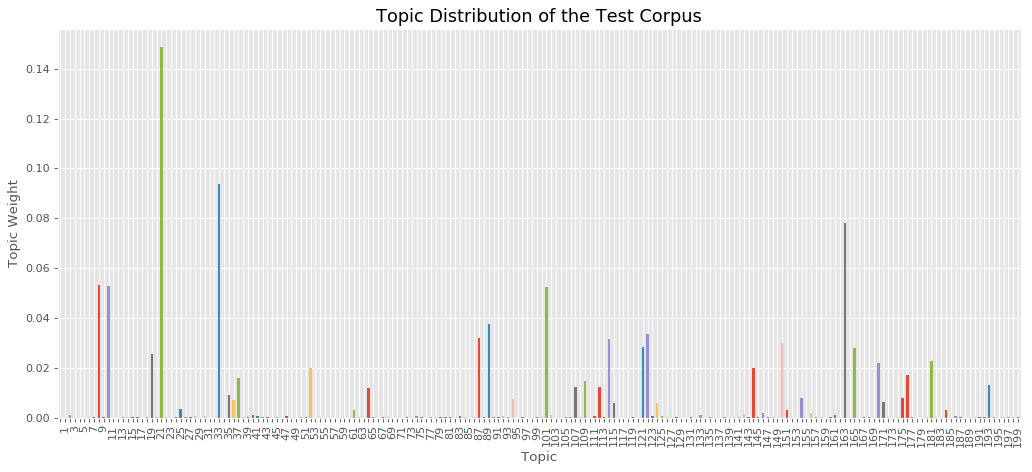

In [11]:
# plot
fig, axes = plt.subplots(figsize=(13, 6), dpi=dpi)
df_plt.plot(ax=axes, 
            kind='bar', 
            x='topic', 
            y='weight', 
            legend=False)
axes.set_title('Topic Distribution of the Test Corpus', fontdict=dict(size=16))
axes.set_ylabel('Topic Weight')
axes.set_xlabel('Topic')
for label in axes.get_xticklabels()[::2]:
    label.set_visible(False)
fig.tight_layout()
plt.xticks(rotation='90')
plt.show()

## 4 Jensen-Shannon Divergence 

>**Similarity query**
>
>Now that we have a topic distribution for a new unseen document, let's say we wanted to find the most similar documents in the corpus. We can do this by comparing the topic distribution of the new document to all the topic distributions of the documents in the corpus. We use the [Jensen-Shannon distance](https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence) metric to find the most similar documents.
>
>What the Jensen-Shannon distance tells us, is which documents are statisically "closer" (and therefore more similar), by comparing the divergence of their distributions. Jensen-Shannon is symmetric, unlike Kullback-Leibler on which the formula is based. This is good, because we want the similarity between documents A and B to be the same as the similarity between B and A.
>
>The formula is described below.
>
>For discrete distirbutions $P$ and $Q$, the Jensen-Shannon divergence, $JSD$ is defined as
>
>$$JSD\left(P||Q\right) = \frac{1}{2}D\left(P||M\right)+\frac{1}{2}D\left(Q||M\right)$$
>
>where $M = \frac{1}{2}\left(P+Q\right)$
>
>and $D$ is the Kullback-Leibler divergence
>
>$$D\left(P||Q\right) = \sum_iP(i)\log\left(\frac{P(i)}{Q(i)}\right)$$
>
>$$\Rightarrow JSD\left(P||Q\right) = \frac{1}{2}\sum_i
>\left[
>P(i)\log\left(\frac{P(i)}{\frac{1}{2}\left(P(i)+Q(i)\right)}\right)
>+
>Q(i)\log\left(\frac{Q(i)}{\frac{1}{2}\left(P(i)+Q(i)\right)}\right)
>\right]$$
>
>The square root of the Jensen-Shannon divergence is the Jensen-Shannon Distance: $\sqrt{JSD\left ( P||Q\right )}$
>
>**The smaller the Jensen-Shannon Distance, the more similar two distributions are (and in our case, the more similar any 2 documents are)**
>
>We can use the scipy implementation of entropy to do this. Entropy calculates the KL divergence.
>
>We got a dense matrix - doc-topic matrix - from MALLET, of size $M\times K$ where $M$ is the number of documents and $K$ is the number of topics.
>
>We will comparing the new unseen document above to the entire train corpora to find which one is most similar to the new document.

**How are we doing that? We have the new documents LDA topic distribution in stored as varibale new doc-topic matrix, and we have the entire corpus of documents topic distributions stored in the dense matrix doc-topic matrix. Then we pass each row of doc-topic matrix through the Jensen-Shannon function above as the Q distribution, while the P distribution remains static as new doc-topic matrix. Then we get the smallest distances and their corresponding index in the array, which we can pass to the train corpora to print out the most similar documents.**

In [12]:
def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    It returns an array of length M where M is the number of documents in the corpus
    """
    # lets keep with the p,q notation above
    p = query.T.values
    q = matrix.T.values
    m = 0.5*(p + q)
    return (0.5*(entropy(p,m) + entropy(q,m)))

In [13]:
def get_similar(query,matrix,k=5):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    #print(sims)
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [14]:
list_sim = get_similar(df_doctopic_test,df_doctopic)

print('The most similar 5 documents row index:',list_sim)

The most similar 5 documents row index: [  69049 2724005 1142500    8684 2839839]


## 5 Recommendation

**Based on the Jensen-Shannon Divergence, we calculated similarity list, and use the list to recommend similar documents.**

**Print meta information:**

In [15]:
#df_similar = df_clean[df_clean.index.isin(most_sim_list)]
df_similar = df_meta[df_meta.index.isin(list_sim)]
df_similar.head()

,id,publisher,region,date,ads
8684,1929443,Bay Of Plenty Times,Bay of Plenty,1879-05-10,False
69049,2421886,Daily Southern Cross,Auckland,1861-05-17,False
1142500,12564083,Star,Canterbury,1893-07-29,False
2724005,28113158,Auckland Star,Auckland,1887-12-23,False
2839839,29000415,Daily Telegraph,Hawke's Bay,1888-11-17,False


**Recommendation 1:**

In [16]:
# linux line number is based on 0
line = list_sim[0] +1 

In [17]:
%%bash -s $line
echo "print the $1 document:"
sed -n "$1p" ../data/dataset/sample/train/train.csv

print the 69050 document:
2421886	THE TIMES ON ITALIAN UNITY.	"THE TIMES ON ITALIAN UNITY.There are moments in the history of nations of an importance so transcendant and so overpowering that they combine and lesumo Ih themselves the wrongs, the agonies, and the Lopes of centuries, and raise men, ia the consciousness of a common sentiment and the transport of an ii repressible enthusiasm, far above the cares and interests, the small joys and paltry sorrows, of ordinary lite. Such moments are the poetry of histoiy, and, though tbe ideal which hah for the moment displaced the actual is fleeting and transitoiy, andthough the sordid caies of oidiuary existence once more a«seit their empire of a mind for a time laised above them, they stand like beacons in the dieaiy annals of mankind, and attiact the genius of all ages to study and understand them, Just as America has achieved the inglorious exploit of tearing heisclf to pieces aud pounding into dust the solid gronite of her institutions, 

**Recommendation 2:**

In [18]:
# linux line number is based on 0
line = list_sim[1] +1 

In [19]:
%%bash -s $line
echo "print the $1 document:"
sed -n "$1p" ../data/dataset/sample/train/train.csv

print the 2724006 document:
28113158	UNKNOWN	"UNKNOWN![| %ypvii grcnte,ey I '-lie purpose .of iablishment of ■''\"'twas? - '*v*S r -»» * J \"|i\"*'V<(tri'J- i 'i is -'-• 'ti — | ior>|fceiv and if ''Si.'applied to tWial Govemm |S|jfor,stesii%ng S^^^^fk&r.,,"


**Recommendation 3:**

In [20]:
# linux line number is based on 0
line = list_sim[2] +1 

In [21]:
%%bash -s $line
echo "print the $1 document:"
sed -n "$1p" ../data/dataset/sample/train/train.csv

print the 1142501 document:
12564083	THEIR WAY.	"THEIR WAY.Bi ffi h ' : \" How de toifrtit-yitofrt\"Nothing.\". , : , \" Then why did she go ahoppinfr P\" \"To see if she could find anything that would make her want Bourething.\""


**Recommendation 4:**

In [22]:
# linux line number is based on 0
line = list_sim[3] +1 

In [23]:
%%bash -s $line
echo "print the $1 document:"
sed -n "$1p" ../data/dataset/sample/train/train.csv

print the 8685 document:
1929443	CORRESPONDENCE	CORRESPONDENCETl)0 Kilitov.is fk'sivoiw of alTonlijij* every vciis.»»:il)lo futility fi'v the f'iswissiun of' iu'W.ic sjiil'jccfs,; ljut it must lie (iistinct y ini(lcr.stno(! liiat lie is in no way rc.si»)iisiliie for the opinions oxjiriwbvil. by (jonvsj.on-,, 'ilcnts. ■ ' ■ . ' - ■ .


In [24]:
# linux line number is based on 0
line = list_sim[4] +1 

In [25]:
%%bash -s $line
echo "print the $1 document:"
sed -n "$1p" ../data/dataset/sample/train/train.csv

print the 2839840 document:
29000415	Untitled	"Tlte e.itii'e iloor of the liirfrc carpet eliow ~„,„„ N,;-l and Cloho mado >mn a bio for JL.jldir\" their nsii.-il ChiistinaH cshtbii.on Th-'.-'IiDW in consequence complete, it contains v wun.lurful n.iscelb.ne.us •icv'.'-tm-nt of unpfnl u.-fii'lcx, in addition to toys awl tiich other things to please and gratify the vigitpV; Inaction invited. }Vdiuis;;i'ju tret-'v ' ;"


**We see the results seem make no sense. The process should be fine, the reason is that the doc-topic matrix of the test corpus is not reasonable, which means MALLET did not give a acceptable inferring output. We take the further digging about MALLET inferring issues as future work.**

---

In [26]:
sc.stop()
gc.collect()

31